In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [17]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [18]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [19]:
# build the dataset
block_size = 3 # context length : how many characters do we take to predict the next one?
def build_dataset(words):
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)  
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80% training set
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% dev=validation set
Xte, Yte = build_dataset(words[n2:])      # 10% test set

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [20]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Xtr = Xtr.to(device)
Ytr = Ytr.to(device)
Xdev = Xdev.to(device)
Ydev = Ydev.to(device)
Xte = Xte.to(device)
Yte = Yte.to(device)

Using device : cuda


### ok biolerplate done, now we get to the action:

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients

def cmp(s, dt, t):
    '''
    comparing manual gradients to PyTorch gradients
    '''
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [31]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

seed_num = 2147483647
g = torch.Generator().manual_seed(seed_num)

# torch.randn
# size         : defining the shape of the output tensor   
C = torch.randn((vocab_size,n_embd), generator=g).to(device)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size) ** 0.5 
W1 = W1.to(device)
b1 = torch.randn(n_hidden,generator=g) * 0.001
b1 = b1.to(device)

# Layer 2
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01 # we want roughly zero at logits
W2 = W2.to(device)
b2 = torch.randn(vocab_size,generator=g) * 0 # at initialization, bias starts with 0, because we want roughly zero at logits.
b2 = b2.to(device)

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)).to(device)
bnbias = torch.zeros((1, n_hidden)).to(device)


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

12097


In [32]:
C.shape

torch.Size([27, 10])

In [33]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# construct a minibatch

# torch.randint
# 0            : 뽑을 수 있는 가장 작은 정수 (포함)
# Xtr.shape[0] : 뽑을 수 있는 가장 큰 정수, 이 경우 데이터셋의 총 샘플 수 (미포함)
# (batch_size,): 결과 텐서의 크기, 이 경우 (32) 

# batch_size 만큼 랜덤하게 idx 번호를 뽑는다.
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) 
# 뽑은 idx 번호로 인덱싱해서 미니 배치를 만든다.
# 미니 배치 shape >>> Xb ([32,3]), Yb ([32])
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [34]:
# forward pass, 'chunkated' into smaller steps that are possible to backward one at a time
emb = C[Xb] # embed the characters into vectors

# C : 임베딩 테이블, 27(문자 개수) * 10(임베딩 차원)
# Xb : 배치 데이터, 32(배치 사이즈) * 3(문자 인덱스)

# C[Xb]는 numpy의 'fancy indexing'처럼 동작
# 핵심은, C의 행이 문자 개수만큼, Xb의 열이 문자 인덱스라는 점

# Xb의 각 문자 인덱스를 행 번호로 해서, C에서 (1,10)의 tensor를 lookup
# 따라서 emb.shape는 ([32,3,10])

In [36]:
# emb.shape[0] = 32
# embcat.shape == ([32,30])
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
# W1.shape == ([30,200]) == ([block_size * n_embd, n_hidden])
# b1.shape == ([200, 1])
# hprebn.shape == ([32,200])
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer
bnmeani = 1/n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim = True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

### softmax에서 max 값을 빼는 이유

exp는 $y^{i} = e^{x_i}$이다.  
즉, logits를 승수로 한다.  
이때, logits가 아주 크면, 지수함수이므로 결과값이 무한대에 가까워질 수 있다.  

따라서 logit에서 max값을 빼준다.  

### logit에서 max값을 빼주어도, softmax 결과는 같은 이유.

softmax 수식으로 보면,
$$\dfrac{e^{x_i - m}}{\sum_j{e^{x_j - m}}} = \dfrac{e^{x_i} \cdot e^{-m}}{\sum_j{e^{x_j}} \cdot e^{-m}} = \dfrac{e^{x_i}}{\sum_j{e^{x_j}}}$$

즉, 분모 분자에 같은 값을 곱한 것과 같으므로, softmax 결과는 같다.

In [37]:
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3147, device='cuda:0', grad_fn=<NegBackward0>)

In [64]:
# Exercise 1 : backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# f = (a + b + c) / 3 일 때, df/da = 1/3
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

# dx/d log(x) == 1/x
# local derivative : (1.0 / probs)
# chain : dlogprobs
dprobs = (1.0 / probs) * dlogprobs

# probs = counts * counts_sum_inv에서, dcounts_sum_inv 구하기
# counts.shape : ([32,27])
# counts_sum_inv.shape : ([32,1])
# local gradient : counts
# upstream gradient : dprobs
# counts_sum_inv[i, 0] 하나의 값이 probs[i, :] 전체 행에 영향을 주었으므로, 역방향에서는 그 행의 모든 gradient를 받아야 한다.
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)

# probs = counts * counts_sum_inv에서, dcounts 구하기
# local gradient : counts_sum_inv
# upstream gradient : dprobs
dcounts = counts_sum_inv * dprobs

# counts_sum_inv = counts_sum ** -1에서, dcounts_sum 구하기
# d/dx x**-1 : x**-2
# local gradient : -counts_sum**-2
# upstream gradient : dcounts_sum_inv
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

# counts_sum = counts.sum(1, keepdim=True)에서, 
# local gradient : 1 (덧셈 연산에서 각 입력값의 미분은 1이기 때문)
# upstream gradient : dcounts_sum
# counts[i, j]가 변하면:
#   probs[i, j]에 직접 영향 (첫 번째 경로)
#   counts_sum[i, 0]에 영향을 주고, 
#   이것이 다시 probs[i, :] 전체에 영향 (두 번째 경로)
#   따라서 각 counts element는 두 경로의 gradient를 모두 받아야 하며, += 연산자로 누적한다.
dcounts += torch.ones_like(counts) * dcounts_sum

# counts = norm_logits.exp()
# local gradient : counts (자기 자신)
# dcounts / dnorm_logits = exp(norm_logits) = counts
dnorm_logits = (counts) * dcounts

# norm_logits = logits - logit_maxes
dlogits = dnorm_logits.clone()

# norm_logits = logits - logit_maxes
# local gradient : -1
# ∂norm_logits/∂logit_maxes = ∂(logits - logit_maxes)/∂logit_maxes = -1
# upstream gradient : dnorm_logits
# 브로드캐스팅 역방향 규칙으로 합산해야한다.
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

# logit_maxes = logits.max(1, keepdim=True).values
# Max 연산은 특성 상 최댓값을 가진 위치에서만 gradient가 전달된다.
# local gradient 찾는 법
# 각 배치에서 최댓값을 찾는다. 
# -> logits.max(1).indices : 각 행에서 최댓값의 인덱스
# 이를 one-hot 벡터로 변환
# -> F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes 

# logits = h @ W2 + b2 
# backward paths of a matrix multiply is a matrix multiply 
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

# h = torch.tanh(hpreact)
# y = tanh(x)일 때, 미분은 1 - y**2
dhpreact = (1.0 - h**2) * dh

# hpreact = bngain * bnraw + bnbias
dbngain = (bnraw * dhpreact).sum(0,keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

# bnraw = bndiff * bnvar_inv
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

# bnvar_inv = (bnvar + 1e-5) ** -0.5
dbnvar = ((-0.5*(bnvar + 1e-5))** -1.5) * dbnvar_inv

# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim = True)
dbndiff2 = ((1.0)/(n-1)) * torch.ones_like(bndiff2) * dbnvar

# bndiff2 = bndiff ** 2
dbndiff += (2*bndiff) * dbndiff2

# bndiff = hprebn - bnmeani
dhprebn = dbndiff.clone()
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)

# bnmeani = 1/n * hprebn.sum(0, keepdim=True)
dhprebn += 1.0/n * torch.ones_like(hprebn) * dbnmeani

# hprebn = embcat @ W1 + b1
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

# embcat = emb.view(emb.shape[0], -1)
demb = dembcat.view(emb.shape)

# emb = C[Xb], Xb @ C와 유사
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
        
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 5.820766091346741e-11
bngain          | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-10
bnbias          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bnraw  

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, tuple of ints dim = None, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, name dim, bool keepdim = False, *, Tensor out = None)


In [65]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3146889209747314 diff: 2.384185791015625e-07


In [66]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


In [70]:
F.softmax(logits, 1)[0]

tensor([0.0347, 0.0453, 0.0353, 0.0384, 0.0397, 0.0361, 0.0346, 0.0350, 0.0378,
        0.0374, 0.0414, 0.0334, 0.0367, 0.0324, 0.0363, 0.0363, 0.0384, 0.0320,
        0.0295, 0.0362, 0.0435, 0.0403, 0.0413, 0.0352, 0.0310, 0.0410, 0.0410],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [67]:
dlogits[0] * n

tensor([ 0.0347, -0.9547,  0.0353,  0.0384,  0.0397,  0.0361,  0.0346,  0.0350,
         0.0378,  0.0374,  0.0414,  0.0334,  0.0367,  0.0324,  0.0363,  0.0363,
         0.0384,  0.0320,  0.0295,  0.0362,  0.0435,  0.0403,  0.0413,  0.0352,
         0.0310,  0.0410,  0.0410], device='cuda:0', grad_fn=<MulBackward0>)

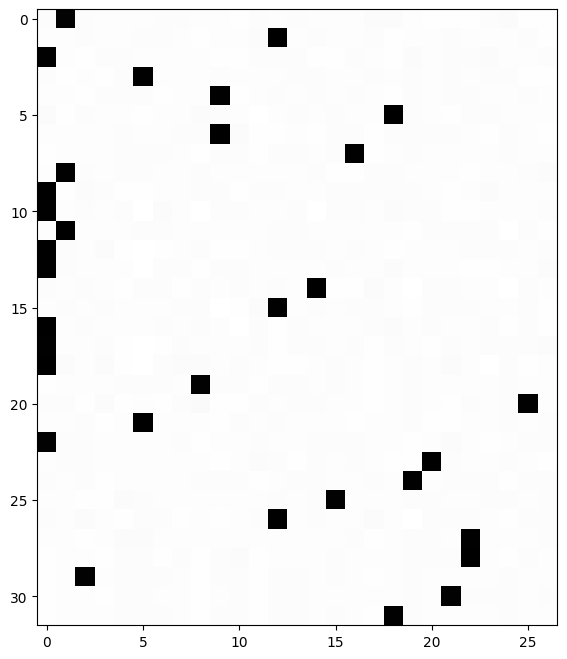

In [69]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.cpu().detach(), cmap = 'gray')

In [ ]:
## Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = None # TODO. my solution is 1 (long) line
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dlogits = F.softmax(logits, 1)
  dlogits[range(n), Yb] -= 1
  dlogits /= n
  # 2nd layer backprop
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  # tanh
  dhpreact = (1.0 - h**2) * dh
  # batchnorm backprop
  dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
  dbnbias = dhpreact.sum(0, keepdim=True)
  dhpreabn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
  # 1st layer
  demcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0)
  # embedding
  demb = dembcat.view(emb.shape)
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
      ix = Xb[k,j]
      dC[ix] += demb[k,j]
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))